In [1]:
from qutip import *
import numpy as np
from scipy import constants
import datetime
import time
import gc
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
from numpy.linalg import inv
from numpy import linalg as LA
from scipy.optimize import minimize_scalar
import math
from scipy.optimize import curve_fit
from scipy.sparse.linalg import eigs

In [2]:
#                       |e> 
#                    --------
#                    /     \
#  Δg, Ωg (probe!)  /       \  Δr, Ωr
#                  /         \ 
#                 /        -------
#             -------        |r> 
#               |g> 

In [2]:
#basis {e,r,g}
N = 3
e = basis(N,0)
r = basis(N,1)
g = basis(N,2)

## Absorption profile of rest ion

In [3]:
def pope(Gamma, Deltar, Omegag, Omegar, Deltag_min, Deltag_max, nn):
    #rhos = []
    pop_e = []
    #tstart = time.time();

    #linbland operator/collapse operators
    #c1 = sqrt(Gamma/3)*p*e.dag()
    c2 = np.sqrt(Gamma/2)*r*e.dag()
    c3 = np.sqrt(Gamma/2)*g*e.dag()
    
    c = [c2,c3]
    #c = [c3]
    c_ops =[spre(c[i])*spost(c[i].dag()) - 0.5*(spre(c[i].dag()*c[i]) + spost(c[i].dag()*c[i])) for i in range(N-1)]

    for Deltag in tqdm(np.linspace(Deltag_min,Deltag_max,nn)):

        #Hamiltonian for a rest ion
        H1 = Deltag*g*g.dag() + Deltar*r*r.dag()
        H2 = -0.5*(Omegag*e*g.dag() + Omegar*e*r.dag() + Omegag*g*e.dag() + Omegar*r*e.dag())
        H = H1 + H2
        

        rho = steadystate(H,c)

        #rhos.append(rho)
    
        pop_e.append(expect(e*e.dag(),rho))
        #print(i)
    
    #print('running time = '+str(time.time()-tstart)+' seconds')
    
    return pop_e#,rhos

In [4]:
#parameters (MHz/2π)
Gamma = 20
Omegar = 17
Omegag = 0.5*Omegar
Deltar = 70
Deltag = Deltar
omega = Gamma/10
Dmin = 67
Dmax = 73
nn = 2000 #Deltap points


params = dict(Gamma=Gamma, Deltar=Deltar, Omegag=Omegag, Omegar=Omegar,
             Deltag_min=Dmin, Deltag_max=Dmax, nn=nn)

In [5]:
pop_e1 = pope(**params)

100%|██████████| 2000/2000 [00:00<00:00, 3273.97it/s]


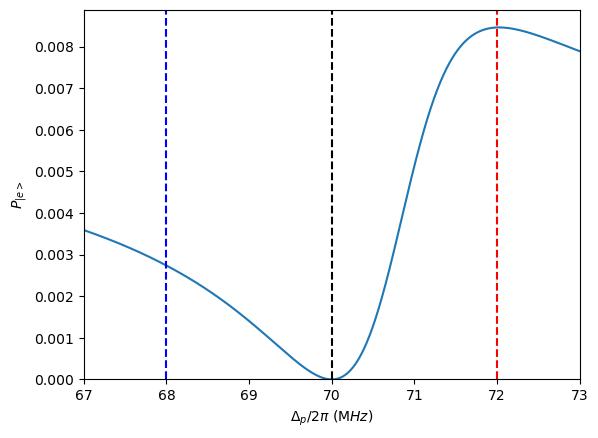

In [6]:
plt.figure()

plt.plot(np.linspace(Dmin,Dmax,nn),pop_e1)


plt.axvline(70+ 2, linestyle='--',color='red')
plt.axvline(70 , linestyle='--',color='black')
plt.axvline(70 - 2, linestyle='--',color='blue')
plt.ylabel('$P_{|e>}$')
plt.xlabel('$Δ_{p}/2π \ (ΜHz)$')
plt.ylim(0)

plt.xlim(67,73)

plt.show()

In [7]:
#parameters G.Morigi PRL (MHz)
Gamma = 20
Omegar = 17
Omegag = 0.75*Omegar
Deltar = 70
Deltag = Deltar
omega = Gamma/10
Dmin = 67
Dmax = 73
nn = 2000 #Deltap points


params = dict(Gamma=Gamma, Deltar=Deltar, Omegag=Omegag, Omegar=Omegar,
             Deltag_min=Dmin, Deltag_max=Dmax, nn=nn)

In [8]:
pop_e2 = pope(**params)

100%|██████████| 2000/2000 [00:00<00:00, 3461.96it/s]


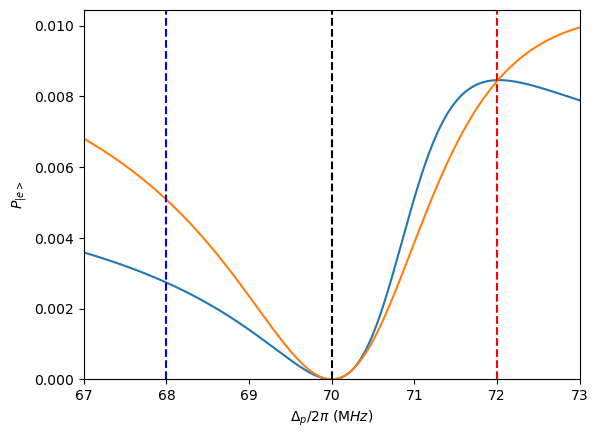

In [9]:
plt.figure()

plt.plot(np.linspace(Dmin,Dmax,nn),pop_e1)
plt.plot(np.linspace(Dmin,Dmax,nn),pop_e2)


plt.axvline(70+ 2, linestyle='--',color='red')
plt.axvline(70 , linestyle='--',color='black')
plt.axvline(70 - 2, linestyle='--',color='blue')
plt.ylabel('$P_{|e>}$')
plt.xlabel('$Δ_{p}/2π \ (ΜHz)$')
plt.ylim(0)

plt.xlim(67,73)

plt.show()

In [10]:
#parameters G.Morigi PRL (MHz)
Gamma = 20
Omegar = 17
Omegag = Omegar
Deltar = 70
Deltag = Deltar
omega = Gamma/10
Dmin = 67
Dmax = 73
nn = 2000 #Deltap points
step = (Dmax-Dmin)/nn


params = dict(Gamma=Gamma, Deltar=Deltar, Omegag=Omegag, Omegar=Omegar,
             Deltag_min=Dmin, Deltag_max=Dmax, nn=nn)

In [11]:
pop_e3 = pope(**params)

100%|██████████| 2000/2000 [00:00<00:00, 3262.84it/s]


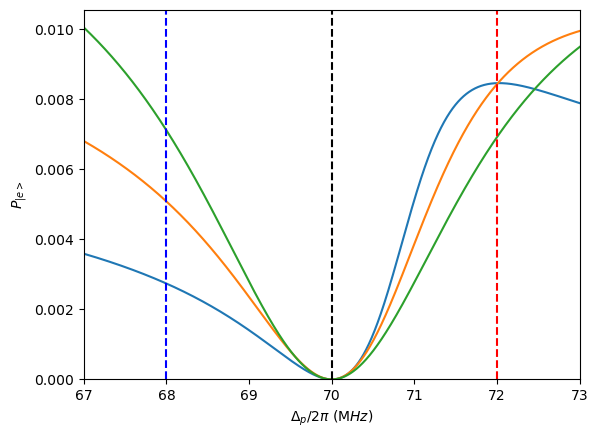

In [12]:
plt.figure()
plt.plot(np.linspace(Dmin,Dmax,nn),pop_e1)
plt.plot(np.linspace(Dmin,Dmax,nn),pop_e2)
plt.plot(np.linspace(Dmin,Dmax,nn),pop_e3)

plt.axvline(70+ 2, linestyle='--',color='red')
plt.axvline(70 , linestyle='--',color='black')
plt.axvline(70 - 2, linestyle='--',color='blue')
plt.ylabel('$P_{|e>}$')
plt.xlabel('$Δ_{p}/2π \ (ΜHz)$')
plt.ylim(0)

plt.xlim(67,73)
plt.show()

In [13]:
eta=0.01
step = (Dmax-Dmin)/nn

In [14]:
Deltar

70

In [15]:
wabs = eta**2*2*np.pi*Gamma*np.array([pop_e1[int((Deltar+omega - Dmin)/step)] - pop_e1[int((Deltar - omega - Dmin)/step)], 
                 pop_e2[int((Deltar+omega - Dmin)/step)] - pop_e2[int((Deltar - omega - Dmin)/step)],
                 pop_e3[int((Deltar+omega - Dmin)/step)] - pop_e3[int((Deltar-omega - Dmin)/step)]
                ])

In [16]:
wabs

array([ 7.19158005e-05,  4.21302712e-05, -2.40115542e-06])

## Fictitious lasers method

In [17]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [18]:
def steck(Gamma, Deltar, Deltag, Omegar, Omegag,Delta,eta): #fictitious lasers method

    #Rest Hamiltonian
    H1 = Deltag*g*g.dag() + Deltar*r*r.dag()
    H2 = -0.5*(Omegag*e*g.dag() + Omegar*e*r.dag() + Omegag*g*e.dag() + Omegar*r*e.dag())
    H0 = H1 + H2

    c2 = np.sqrt(Gamma/2)*r*e.dag()
    c3 = np.sqrt(Gamma/2)*g*e.dag()

    c = [c2,c3]

    rho0 = steadystate(H0,c)

    L0 = 0*spre(c[0])*spost(c[0].dag())
    for i in range(len(c)):
        L0 += spre(c[i])*spost(c[i].dag()) - 0.5*(spre(c[i].dag()*c[i]) + spost(c[i].dag()*c[i]))

    L0 += -1j*(spre(H0) - spost(H0))

    #L0 = np.array(L0)
    L0 = L0.data_as('ndarray')

    #Fuctitious lasers
    Ht = -0.5*(eta*Omegag*g*e.dag() - eta*Omegar*r*e.dag())
    L1 = -1j*(spre(Ht) - spost(Ht))

    #L1 = np.array(L1)
    L1 = L1.data_as('ndarray')

    #Ht1 = 0.5*(1j*eta*Omegag*e*g.dag() -1j*eta*Omegar*e*r.dag())
    Ht1 = Ht.dag()
    L_1 = -1j*(spre(Ht1) - spost(Ht1))

    #L_1 = np.array(L_1)
    L_1 = L_1.data_as('ndarray')



    #matrix continued fractions method 
    #S3 = -np.matmul(inv(L0-3j*Delta*np.eye(N**2)),L1)
    #S2 = -np.matmul(inv(L0-2j*Delta*np.eye(N**2)+ np.matmul(L_1,S3)),L1)
    S2 = -np.matmul(inv(L0-2j*Delta*np.eye(N**2)),L1)
    S1 = -np.matmul(inv(L0-1j*Delta*np.eye(N**2) + np.matmul(L_1,S2)),L1) 
    #S1 = -np.matmul(inv(L0-1j*Delta*np.eye(N**2)),L1) 

    #T_3 = -np.matmul(inv(L0+3j*Delta*np.eye(N**2)),L_1)
    #T_2 = -np.matmul(inv(L0+2j*Delta*np.eye(N**2)+ np.matmul(L1,T_3)),L_1)
    T_2 = -np.matmul(inv(L0+2j*Delta*np.eye(N**2)),L_1)
    T_1 = -np.matmul(inv(L0+1j*Delta*np.eye(N**2)+ np.matmul(L1,T_2)),L_1)
    #T_1 = -np.matmul(inv(L0+1j*Delta*np.eye(N**2)),L_1)
    
    L = np.matmul(L_1,S1) + L0 +np.matmul(L1,T_1)
    
    eigenvalues, eigenvectors = LA.eig(L)

    idx = find_nearest(eigenvalues, 0+0j)
    rhoss = eigenvectors[:,idx]

    #fixing column stacking
    rhos = np.zeros((N,N),dtype='complex64')
    for i in range(N):
        for j in range(N):
            rhos[j,i] = rhoss[j+i*N]

    rho = Qobj(rhos)
    if rho.tr() != 0:
        rho = rho/rho.tr()

    rho_ = operator_to_vector(rho)
    #rho_ = np.array(rho_)
    rho_ = rho_.data_as('ndarray')

    rho1 = np.matmul(S1,rho_)
    #rho2 = np.matmul(S2,rho_)
    #rho3 = np.matmul(S3,rho_)

    rho_1 = np.matmul(T_1,rho_)
    #rho_2 = np.matmul(T_2,rho_)
    #rho_3 = np.matmul(T_3,rho_)

    rhos1 = np.zeros((N,N),dtype='complex64')
    #rhos2 = np.zeros((N,N),dtype='complex64')
    #rhos3 = np.zeros((N,N),dtype='complex64')
    rhos_1 = np.zeros((N,N),dtype='complex64')
    #rhos_2 = np.zeros((N,N),dtype='complex64')
    #rhos_3 = np.zeros((N,N),dtype='cdef steck(Gamma, Deltar, Deltag, Omegar, Omegag,Delta,eta): #fictitious lasers method

    #Rest Hamiltonian
    H1 = Deltag*g*g.dag() + Deltar*r*r.dag()
    H2 = -0.5*(Omegag*e*g.dag() + Omegar*e*r.dag() + Omegag*g*e.dag() + Omegar*r*e.dag())
    H0 = H1 + H2

    c2 = np.sqrt(Gamma/2)*r*e.dag()
    c3 = np.sqrt(Gamma/2)*g*e.dag()

    c = [c2,c3]

    rho0 = steadystate(H0,c)

    L0 = 0*spre(c[0])*spost(c[0].dag())
    for i in range(len(c)):
        L0 += spre(c[i])*spost(c[i].dag()) - 0.5*(spre(c[i].dag()*c[i]) + spost(c[i].dag()*c[i]))

    L0 += -1j*(spre(H0) - spost(H0))

    #L0 = np.array(L0)
    L0 = L0.data_as('ndarray')

    #Fuctitious lasers
    H1 = -0.5*(1j*eta*Omegag*g*e.dag() - 1j*eta*Omegar*r*e.dag())
    L1 = -1j*(spre(H1) - spost(H1))

    #L1 = np.array(L1)
    L1 = L1.data_as('ndarray')

    #Ht1 = 0.5*(1j*eta*Omegag*e*g.dag() -1j*eta*Omegar*e*r.dag())
    H_1 = H1.dag()
    L_1 = -1j*(spre(H_1) - spost(H_1))

    #L_1 = np.array(L_1)
    L_1 = L_1.data_as('ndarray')



    #matrix continued fractions method 
    #S3 = -np.matmul(inv(L0-3j*Delta*np.eye(N**2)),L1)
    #S2 = -np.matmul(inv(L0-2j*Delta*np.eye(N**2)+ np.matmul(L_1,S3)),L1)
    S2 = -np.matmul(inv(L0-2j*Delta*np.eye(N**2)),L1)
    S1 = -np.matmul(inv(L0-1j*Delta*np.eye(N**2) + np.matmul(L_1,S2)),L1) 
    #S1 = -np.matmul(inv(L0-1j*Delta*np.eye(N**2)),L1) 

    #T_3 = -np.matmul(inv(L0+3j*Delta*np.eye(N**2)),L_1)
    #T_2 = -np.matmul(inv(L0+2j*Delta*np.eye(N**2)+ np.matmul(L1,T_3)),L_1)
    T_2 = -np.matmul(inv(L0+2j*Delta*np.eye(N**2)),L_1)
    T_1 = -np.matmul(inv(L0+1j*Delta*np.eye(N**2)+ np.matmul(L1,T_2)),L_1)
    #T_1 = -np.matmul(inv(L0+1j*Delta*np.eye(N**2)),L_1)
    
    L = np.matmul(L_1,S1) + L0 +np.matmul(L1,T_1)
    
    eigenvalues, eigenvectors = LA.eig(L)

    idx = find_nearest(eigenvalues, 0+0j)
    rhoss = eigenvectors[:,idx]

    #fixing column stacking
    rhos = np.zeros((N,N),dtype='complex64')
    for i in range(N):
        for j in range(N):
            rhos[j,i] = rhoss[j+i*N]

    rho = Qobj(rhos)
    if rho.tr() != 0:
        rho = rho/rho.tr()

    rho_ = operator_to_vector(rho)
    #rho_ = np.array(rho_)
    rho_ = rho_.data_as('ndarray')

    rho1 = np.matmul(S1,rho_)
    #rho2 = np.matmul(S2,rho_)
    #rho3 = np.matmul(S3,rho_)

    rho_1 = np.matmul(T_1,rho_)
    #rho_2 = np.matmul(T_2,rho_)
    #rho_3 = np.matmul(T_3,rho_)

    rhos1 = np.zeros((N,N),dtype='complex64')
    #rhos2 = np.zeros((N,N),dtype='complex64')
    #rhos3 = np.zeros((N,N),dtype='complex64')
    rhos_1 = np.zeros((N,N),dtype='complex64')
    #rhos_2 = np.zeros((N,N),dtype='complex64')
    #rhos_3 = np.zeros((N,N),dtype='complex64')
    for i in range(N):
        for j in range(N):
            rhos1[j,i] = rho1[j+i*N]
            #rhos2[j,i] = rho2[j+i*N]
            #rhos3[j,i] = rho3[j+i*N]
            rhos_1[j,i] = rho_1[j+i*N]
            #rhos_2[j,i] = rho_2[j+i*N]
            #rhos_3[j,i] = rho_3[j+i*N]
            
    Rho1 = Qobj(rhos1)
    #Rho2 = Qobj(rhos2)
    #Rho3 = Qobj(rhos3)
    Rho_1 = Qobj(rhos_1)
    #Rho_2 = Qobj(rhos_2)
    #Rho_3 = Qobj(rhos_3)
       

    return 2*np.pi*(eta*Omegag/2*expect(g*e.dag(),Rho_1)  \
                            -eta*Omegar/2*expect(r*e.dag(),Rho_1)   \
                            +eta*Omegag/2*(expect(e*g.dag(),Rho1) ) \
                            -eta*Omegar/2*(expect(e*r.dag(),Rho1)  ))

In [19]:
#parameters G.Morigi PRL (MHz)
eta = 0.01
Gamma = 20
Omegar = 17
Omegag = 0.5*Omegar
Deltar = 70
Deltag = Deltar
omega = Gamma/10

#parameters lutetium
#deltab1 = 11.2
#deltab2 = 10.5

Dmin_ = -3
Dmax_ = 3
nn_ = 1000 #Deltap points
step=(Dmax_-Dmin_)/nn_

params = dict(Gamma=Gamma, Deltar=Deltar, Deltag=Deltag, Omegar=Omegar,Omegag=Omegag, Delta=omega, eta=eta)

In [20]:
abs1 = []
for delta in tqdm(np.linspace(Dmin_,Dmax_,nn_)):
    abs1.append(steck(Gamma=Gamma, Deltar=Deltar, Deltag=Deltag, Omegar=Omegar,Omegag=Omegag, Delta=delta, eta=eta))

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\kfouka\AppData\Local\Temp\ipykernel_14912\1573280995.py:176: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos1[j,i] = rho1[j+i*N]
C:\Users\kfouka\AppData\Local\Temp\ipykernel_14912\1573280995.py:179: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos_1[j,i] = rho_1[j+i*N]
100%|██████████| 1000/1000 [00:02<00:00, 391.28it/s]


c:\Users\kfouka\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\kfouka\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


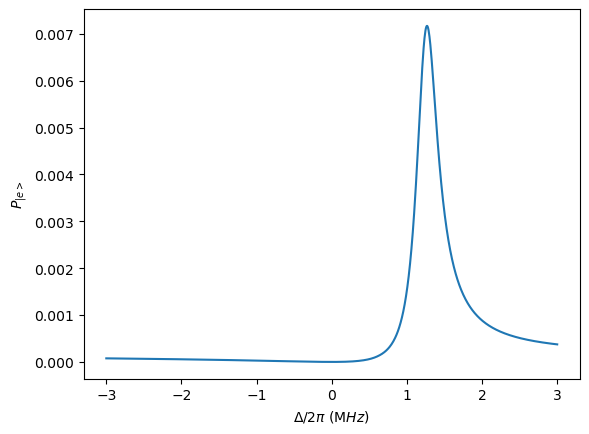

In [21]:
plt.figure()
#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(np.linspace(Dmin_,Dmax_,nn_),abs1)
#plt.plot(np.linspace(Dmin_,Dmax_,nn_),pop_es32pi)
plt.ylabel('$P_{|e>}$')
plt.xlabel('$Δ/2π \ (ΜHz)$')
#plt.ylim(0)

#plt.xlim(18,28)

#plt.savefig("Lu_eit_e_pi.png",bbox_inches = "tight")
plt.show()

In [22]:
#parameters G.Morigi PRL (MHz)
eta = 0.01
Gamma = 20
Omegar = 17
Omegag = 0.75*Omegar
Deltar = 70
Deltag = Deltar
omega = Gamma/10

#parameters lutetium
#deltab1 = 11.2
#deltab2 = 10.5

Dmin_ = -3
Dmax_ = 3
nn_ = 1000 #Deltap points
step=(Dmax_-Dmin_)/nn_

params = dict(Gamma=Gamma, Deltar=Deltar, Deltag=Deltag, Omegar=Omegar,Omegag=Omegag, Delta=omega, eta=eta)

In [23]:
abs2 = []
for delta in tqdm(np.linspace(Dmin_,Dmax_,nn_)):
    abs2.append(steck(Gamma=Gamma, Deltar=Deltar, Deltag=Deltag, Omegar=Omegar,Omegag=Omegag, Delta=delta, eta=eta))

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\kfouka\AppData\Local\Temp\ipykernel_14912\1573280995.py:176: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos1[j,i] = rho1[j+i*N]
C:\Users\kfouka\AppData\Local\Temp\ipykernel_14912\1573280995.py:179: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos_1[j,i] = rho_1[j+i*N]
100%|██████████| 1000/1000 [00:02<00:00, 391.45it/s]


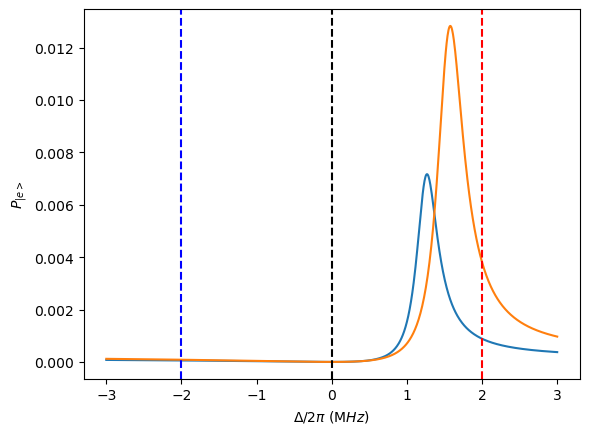

In [24]:
plt.figure()
#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(np.linspace(Dmin_,Dmax_,nn_),abs1)
plt.plot(np.linspace(Dmin_,Dmax_,nn_),abs2)
plt.axvline(omega, linestyle='--',color='red')
plt.axvline(0, linestyle='--',color='black')
plt.axvline( - omega, linestyle='--',color='blue')
plt.ylabel('$P_{|e>}$')
plt.xlabel('$Δ/2π \ (ΜHz)$')
#plt.ylim(0)

#plt.xlim(18,28)

#plt.savefig("Lu_eit_e_pi.png",bbox_inches = "tight")
plt.show()

In [25]:
#parameters G.Morigi PRL (MHz)
eta = 0.01
Gamma = 20
Omegar = 17
Omegag = Omegar
Deltar = 70
Deltag = Deltar
omega = Gamma/10

Dmin_ = -3
Dmax_ = 3
nn_ = 1000 #Deltap points
step=(Dmax_-Dmin_)/nn_

In [26]:
abs3 = []
for delta in tqdm(np.linspace(Dmin_,Dmax_,nn_)):
    abs3.append(steck(Gamma=Gamma, Deltar=Deltar, Deltag=Deltag, Omegar=Omegar,Omegag=Omegag, Delta=delta, eta=eta))

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\kfouka\AppData\Local\Temp\ipykernel_14912\1573280995.py:176: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos1[j,i] = rho1[j+i*N]
C:\Users\kfouka\AppData\Local\Temp\ipykernel_14912\1573280995.py:179: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos_1[j,i] = rho_1[j+i*N]
100%|██████████| 1000/1000 [00:02<00:00, 401.33it/s]


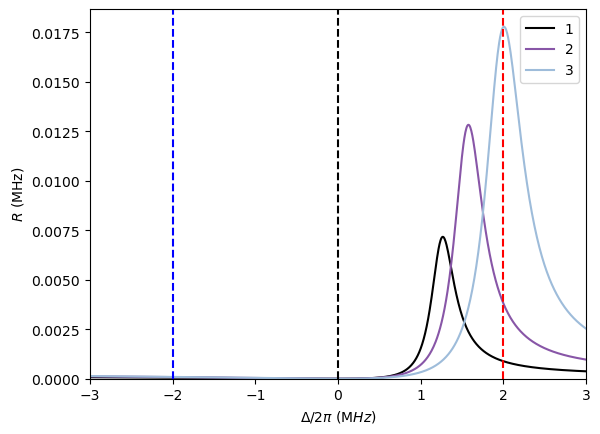

In [27]:
plt.figure()

plt.plot(np.linspace(Dmin_,Dmax_,nn_),abs1,color='black',label='1')
plt.plot(np.linspace(Dmin_,Dmax_,nn_),abs2,color='#8856a7',label='2')
plt.plot(np.linspace(Dmin_,Dmax_,nn_),abs3,color='#9ebcda',label='3')
plt.axvline( omega, linestyle='--',color='red')
plt.axvline(0, linestyle='--',color='black')
plt.axvline( - omega, linestyle='--',color='blue')
plt.ylabel('$R$ (MHz)')
plt.xlabel('$Δ/2π \ (ΜHz)$')
plt.ylim(0)
plt.xlim(-3,3)
#plt.yscale("log")

#plt.xlim(18,28)
plt.legend()

#plt.savefig("Steck_comp.png",bbox_inches = "tight")
plt.show()

In [28]:
(abs1[int((+ Gamma/10 -Dmin_)/step)]-abs1[int(( - Gamma/10-Dmin_)/step)])

(0.0008239441971544746+1.0644129937770483e-19j)

In [29]:
(abs2[int(( Gamma/10 -Dmin_)/step)]-abs2[int(( - Gamma/10 -Dmin_)/step)])

(0.003694029113654354-1.277295592532458e-19j)

In [30]:
(abs3[int(( Gamma/10 -Dmin_)/step)]-abs3[int(( - Gamma/10 -Dmin_)/step)])

(0.017686214618629667+0j)

In [31]:
wsteck = np.array([abs1[int((+ Gamma/10 -Dmin_)/step)]-abs1[int(( - Gamma/10-Dmin_)/step)], abs2[int((+ Gamma/10 -Dmin_)/step)]-abs2[int(( - Gamma/10-Dmin_)/step)],
          abs3[int((+ Gamma/10 -Dmin_)/step)]-abs3[int(( - Gamma/10-Dmin_)/step)]])

In [32]:
wsteck

array([0.00082394+1.06441299e-19j, 0.00369403-1.27729559e-19j,
       0.01768621+0.00000000e+00j])

## Phonon rate cooling rate

In [33]:
def S_(Gamma, Deltar, Deltag, Omegar, Omegag,omega,eta):

     #Gamma=2*np.pi*Gamma
    H1 = 2*np.pi*(Deltag*g*g.dag() + Deltar*r*r.dag())
    H2 = -np.pi*(Omegag*e*g.dag() + Omegar*e*r.dag() + Omegag*g*e.dag() + Omegar*r*e.dag())
    H0 = H1 + H2

    c2 = np.sqrt(2*np.pi*Gamma/2)*r*e.dag()
    c3 = np.sqrt(2*np.pi*Gamma/2)*g*e.dag()

    c = [c2,c3]
    rho = steadystate(H0,c) #!

    L0 = 0*spre(c[0])*spost(c[0].dag())
    for i in range(len(c)):
        L0 += spre(c[i])*spost(c[i].dag()) - 0.5*(spre(c[i].dag()*c[i]) + spost(c[i].dag()*c[i]))

    L0 += -1j*(spre(H0) - spost(H0))
    
    #L0 = np.array(L0)
    L0 = L0.data_as('ndarray')

    V1 = np.pi*1j*(eta*Omegag*e*g.dag() - eta*Omegar*e*r.dag())
    V1 = V1 + V1.dag()
    V1rho = V1*rho

    V1rho = operator_to_vector(V1rho)
    #V1rho = np.array(V1rho)
    V1rho = V1rho.data_as('ndarray')

    eye = np.eye(N**2)
    inve = -inv((L0+1j*2*np.pi*omega*eye))

    s = inve@V1rho

    S = np.zeros((N,N),dtype=np.complex_)
    for i in range(N):
        for j in range(N):
            S[j,i] = s[N*i+j][0]
            
    #V1 = np.array(V1)
    V1 =V1.data_as('ndarray')
    S = np.matmul(V1,S)

    return np.matrix.trace(S)

In [34]:
#parameters G.Morigi PRL (MHz)
eta = 0.01
Gamma = 20
Omegar = 17
Omegag = 0.5*Omegar
Deltar = 70
Deltag = Deltar
omega = Gamma/10

#rho=rho1

In [35]:
Am1 = S_(Gamma, Deltar, Deltag, Omegar, Omegag,omega,eta)
Am1

(0.00044257117013606144+0.00118802698483399j)

In [36]:
Ap1 = S_(Gamma, Deltar, Deltag, Omegar, Omegag,-omega,eta)
Ap1

(2.8143105157090082e-05+0.00031845682429319723j)

In [37]:
(2*Am1-2*Ap1).real

0.0008288561299579427

In [38]:
Ss1 = []
for v in tqdm(np.linspace(Dmin_,Dmax_,nn_)):
    Ss1.append(S_(Gamma, Deltar, Deltag, Omegar, Omegag,v,eta))

100%|██████████| 1000/1000 [00:00<00:00, 1041.60it/s]


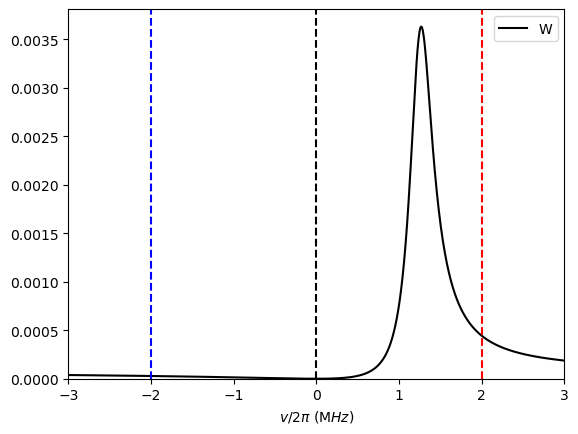

In [39]:
plt.figure()
#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(np.linspace(Dmin_,Dmax_,nn_),Ss1,label='W',color='black')
plt.xlabel('$v/2π \ (ΜHz)$')
plt.ylim(0)
plt.axvline(omega, linestyle='--',color='red')
plt.axvline(0, linestyle='--',color='black')
plt.axvline(-omega, linestyle='--',color='blue')

plt.xlim(-3,3)
plt.legend()


plt.show()

In [40]:
#parameters G.Morigi PRL (MHz)
eta = 0.01
Gamma = 20
Omegar = 17
Omegag = 0.75*Omegar
Deltar = 70
Deltag = Deltar
omega = Gamma/10

In [41]:
Am2 = S_(Gamma, Deltar, Deltag, Omegar, Omegag,omega,eta)
Ap2 = S_(Gamma, Deltar, Deltag, Omegar, Omegag,-omega,eta)

In [42]:
(2*Am2-2*Ap2).real

0.0037395202805660973

In [43]:
Ss2 = []
for v in tqdm(np.linspace(Dmin_,Dmax_,nn_)):
    Ss2.append(S_(Gamma, Deltar, Deltag, Omegar, Omegag, v,eta))

100%|██████████| 1000/1000 [00:00<00:00, 1028.79it/s]


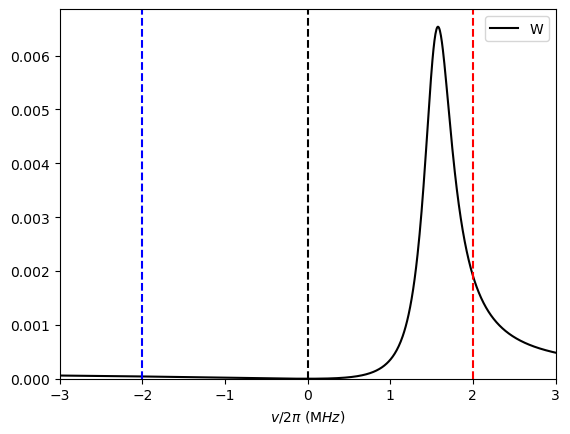

In [44]:
plt.figure()
#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(np.linspace(Dmin_,Dmax_,nn_),Ss2,label='W',color='black')
plt.xlabel('$v/2π \ (ΜHz)$')
plt.ylim(0)
plt.axvline(omega, linestyle='--',color='red')
plt.axvline(0, linestyle='--',color='black')
plt.axvline(- omega, linestyle='--',color='blue')

plt.xlim(-3,3)
plt.legend()


plt.show()

In [45]:
#parameters G.Morigi PRL (MHz)
eta = 0.01
Gamma = 20
Omegar = 17
Omegag = Omegar
Deltar = 70
Deltag = Deltar
omega = Gamma/10

In [46]:
Am3 = S_(Gamma, Deltar, Deltag, Omegar, Omegag,omega,eta)
Ap3 = S_(Gamma, Deltar, Deltag, Omegar, Omegag,-omega,eta)

In [47]:
(2*Am3-2*Ap3).real

0.01805521563040622

In [48]:
Ss3 = []
for v in tqdm(np.linspace(Dmin_,Dmax_,nn_)):
    Ss3.append(S_(Gamma, Deltar, Deltag, Omegar, Omegag, v,eta))

100%|██████████| 1000/1000 [00:00<00:00, 1038.17it/s]


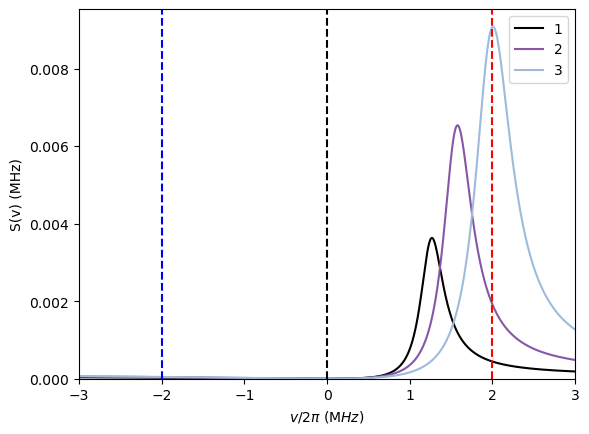

In [49]:
plt.figure()
#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(np.linspace(Dmin_,Dmax_,nn_),Ss1,color='black',label='1')
plt.plot(np.linspace(Dmin_,Dmax_,nn_),Ss2,color='#8856a7',label='2')
plt.plot(np.linspace(Dmin_,Dmax_,nn_),Ss3,color='#9ebcda',label='3')

plt.ylabel('S(v) (MHz)')
plt.xlabel('$v/2π \ (ΜHz)$')
plt.ylim(0)
plt.axvline(omega, linestyle='--',color='red')
plt.axvline(0, linestyle='--',color='black')
plt.axvline(- omega, linestyle='--',color='blue')

plt.xlim(-3,3)
plt.legend()
#plt.savefig("Giovanna_single_comp.png",bbox_inches = "tight")


plt.show()

In [50]:
w = np.array([(2*Am1-2*Ap1).real,(2*Am2-2*Ap2).real,(2*Am3-2*Ap3).real])

## Cooling

In [68]:
t1 = np.loadtxt(""+str(path_name)+"cooling_EIT_Omegag_8.5_Omegar_17_Delta_70_Gamma1_10.0_Gamma2_10.0_eta_0.01.txt")[:, 0]
n1 = np.loadtxt(""+str(path_name)+"cooling_EIT_Omegag_8.5_Omegar_17_Delta_70_Gamma1_10.0_Gamma2_10.0_eta_0.01.txt")[:, 1]

In [69]:
t2 = np.loadtxt(""+str(path_name)+"cooling_EIT_Omegag_12.75_Omegar_17_Delta_70_Gamma1_10.0_Gamma2_10.0_eta_0.01.txt")[:, 0]
n2 = np.loadtxt(""+str(path_name)+"cooling_EIT_Omegag_12.75_Omegar_17_Delta_70_Gamma1_10.0_Gamma2_10.0_eta_0.01.txt")[:, 1]

In [70]:
t3 = np.loadtxt(""+str(path_name)+"cooling_EIT_Omegag_17_Omegar_17_Delta_70_Gamma1_10.0_Gamma2_10.0_eta_0.01.txt")[:, 0]
n3 = np.loadtxt(""+str(path_name)+"cooling_EIT_Omegag_17_Omegar_17_Delta_70_Gamma1_10.0_Gamma2_10.0_eta_0.01.txt")[:, 1]

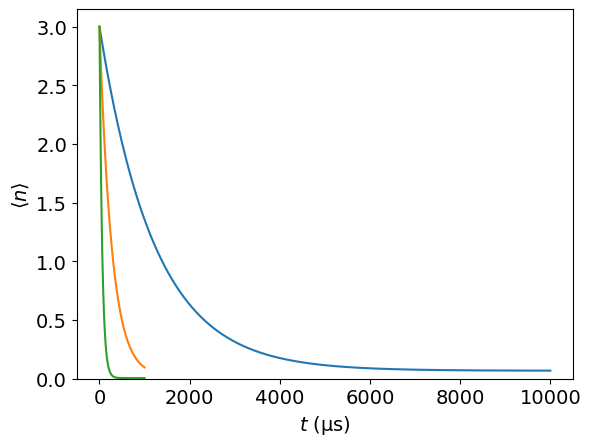

In [71]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(t1,n1)
plt.plot(t2,n2)
plt.plot(t3,n3)

plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (μs)')
plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,2)


#plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [72]:
def func(t,a,b,c):
    return a*np.exp(-b*t) + c*(1-np.exp(-b*t))

In [73]:
p0 = (3, .001,.001)
popt1, pcov = curve_fit(func,t1,n1,p0)
popt1

array([3.00302455e+00, 8.24180969e-04, 6.77601226e-02])

In [74]:
p0 = (3, .001,.001)
popt2, pcov = curve_fit(func,t2,n2,p0)
popt2

array([3.01006544, 0.00365789, 0.01754474])

In [75]:
p0 = (3, .001,.001)
popt3, pcov = curve_fit(func,t3,n3,p0)
popt3

array([3.08542317, 0.01705878, 0.00369935])

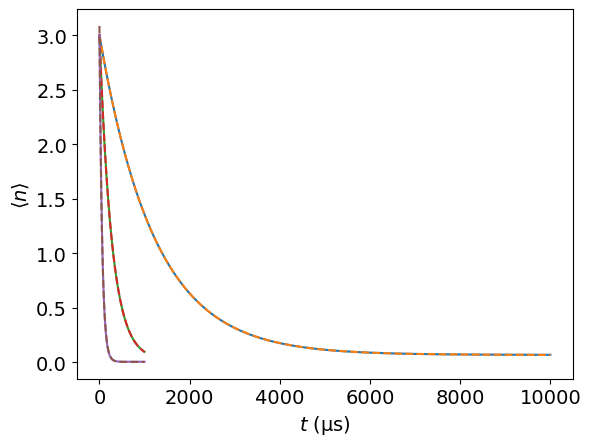

In [76]:

plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(t1,n1)
plt.plot(t1,func(t1, *popt1),'--')
plt.plot(t2,n2)
plt.plot(t2,func(t2, *popt2),'--')
plt.plot(t3,n3)
plt.plot(t3,func(t3, *popt3),'--')



plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (μs)')
#plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,2)
#plt.yscale("log")


#plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [77]:
wexp = [popt1[1],popt2[1],popt3[1]]

In [86]:
plt.rcParams.update({'font.size': 8})

C:\Users\kfouka\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\kfouka\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


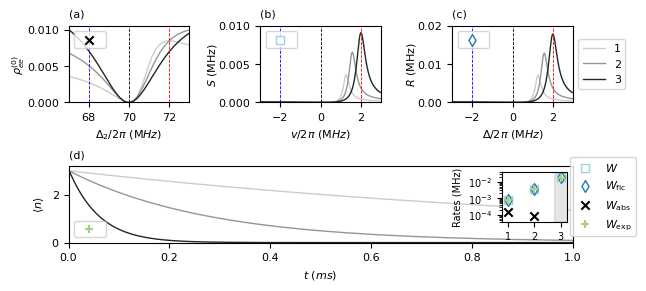

In [102]:
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

fig = plt.figure(constrained_layout=True,figsize=(5.8,2.8))

gs = GridSpec(2, 3, figure=fig)
#gs.update(wspace=0.005, hspace=0.05)
ax1 = fig.add_subplot(gs[0, 0])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))


ax1.set_title(r'(a)',loc='left',fontdict={'fontsize': 8})
ax1.plot(np.linspace(Dmin,Dmax,nn),pop_e1,color='#cccccc',linewidth=1)
ax1.plot(np.linspace(Dmin,Dmax,nn),pop_e2,color='#969696',linewidth=1)
ax1.plot(np.linspace(Dmin,Dmax,nn),pop_e3,color='#252525',linewidth=1)
ax1.scatter([3],2*wabs[-1],marker='x',label='$\,$',color='black')
ax1.axvline(Deltar + omega, linestyle='--',color='red',linewidth=0.6)
ax1.axvline(Deltar, linestyle='--',color='black',linewidth=0.6)
ax1.axvline(Deltar - omega, linestyle='--',color='blue',linewidth=0.6)
ax1.set_xlim(67,73)
ax1.set_ylim(0)
ax1.set_ylabel(r'$\rho_{ee}^{(0)}$',labelpad=0)
ax1.set_xlabel('$Δ_{2}/2π \ (ΜHz)$')
ax1.legend(loc='upper left',alignment='left',handletextpad=0.05,borderpad=0.3)



ax3 = fig.add_subplot(gs[0, 1])
ax3.set_title(r'(b)',loc='left',fontdict={'fontsize': 8})
ax3.plot(np.linspace(Dmin_,Dmax_,nn_),Ss1,color='#cccccc',linewidth=1)
ax3.plot(np.linspace(Dmin_,Dmax_,nn_),Ss2,color='#969696',linewidth=1)
ax3.plot(np.linspace(Dmin_,Dmax_,nn_),Ss3,color='#252525',linewidth=1)
ax3.axvline( omega, linestyle='--',color='red',linewidth=0.6)
ax3.axvline(0, linestyle='--',color='black',label='',linewidth=0.6)
ax3.axvline( - omega, linestyle='--',color='blue',linewidth=0.6)
ax3.scatter([1],w.real[-1],marker='s',label=r'$\,$',color='white',edgecolor = '#a6cee3')
ax3.set_ylabel('$S $ (MHz)',labelpad=0)
ax3.set_xlabel('$v/2π \ (ΜHz)$')
ax3.set_ylim(0,1e-2)
ax3.set_xlim(-3,3)
ax3.legend(loc='upper left',alignment='left',handletextpad=0.05,borderpad=0.3)


ax2 = fig.add_subplot(gs[0, 2])
ax2.set_title(r'(c)',loc='left',fontdict={'fontsize': 8})
line1,=ax2.plot(np.linspace(Dmin_,Dmax_,nn_),abs1,color='#cccccc',label='1',linewidth=1)
line2,=ax2.plot(np.linspace(Dmin_,Dmax_,nn_),abs2,color='#969696',label='2',linewidth=1)
line3,=ax2.plot(np.linspace(Dmin_,Dmax_,nn_),abs3,color='#252525',label='3',linewidth=1)
ax2.axvline( omega, linestyle='--',color='red',linewidth=0.6)
ax2.axvline(0, linestyle='--',color='black',linewidth=0.6)
ax2.axvline( - omega, linestyle='--',color='blue',linewidth=0.6)
line4=ax2.scatter([1,2,3],wsteck.real+10,marker='d',label=r'$\,$',color='white',edgecolor = '#1f78b4')
ax2.set_ylabel('$R$ (MHz)',labelpad=0)
ax2.set_xlabel('$Δ/2π \ (ΜHz)$')
ax2.set_ylim(0,2e-2)
ax2.set_xlim(-3,3)
ax2.ticklabel_format(axis='y', scilimits=[-4, -1])
#ax2.
first_legend =plt.legend(handles=[line1,line2,line3],loc='center left',prop={'size': 8},bbox_to_anchor=(1, 0.5))
ax2.add_artist(first_legend)
second_legend = plt.legend(handles=[line4],loc='upper left',alignment='left',handletextpad=0.05,borderpad=0.3)
#ax2.grid(True)

ax4 = fig.add_subplot(gs[1, :])
ax4.set_title(r'(d)',loc='left',fontdict={'fontsize': 8})
ax4.plot(t1*1e-3,n1,color='#cccccc',linewidth=1)
ax4.plot(t2*1e-3,n2,color='#969696',linewidth=1)
ax4.plot(t3*1e-3,n3,color='#252525',linewidth=1)
ax4.scatter([1,2,3],np.array(wexp)+10,marker='+',label=r'$\,$',color='#a7cf82')
#plt.plot(tlist,ne2)
ax4.set_ylabel(r'$ \langle n \rangle $')
ax4.set_xlabel(r'$t \ (ms)$')
ax4.set_ylim(0,3.2)
ax4.set_xlim(0,1)
ax4.legend(loc='lower left',alignment='left',handletextpad=0.05,borderpad=0.3,columnspacing=0.05)

#plt.xlim(0,100)
#ax4.legend()

inset_ax = inset_axes(ax4, width="13%", height=0.5, loc="upper right")
#inset_ax.set_title(r'(e)',loc='left',fontdict={'fontsize': 8},pad=5)
inset_ax.fill_between(np.linspace(2.75,3.25,1000),y1=4e-5,y2=4e-2, color='grey', alpha=0.2)
inset_ax.scatter([1,2,3],w.real,marker='s',label=r'$W$',color='white',edgecolor = '#a6cee3')
inset_ax.scatter([1,2,3],wsteck.real,marker='d',label=r'$W_{\text{fic}}$',color='white',edgecolor = '#1f78b4')
inset_ax.scatter([1,2,3],2*wabs,marker='x',label=r'$W_{\text{abs}}$',color='black')
inset_ax.scatter([1,2,3],wexp,marker='+',label=r'$W_{\text{exp}}$',color='#a7cf82')
inset_ax.set_xticks([1,2,3])
inset_ax.set_xticklabels(["1","2","3"],fontsize=7)
inset_ax.set_ylim(4e-5,4e-2)
inset_ax.set_xlim(0.75,3.25)
inset_ax.tick_params(labelsize=7)
inset_ax.set_yscale('log')
inset_ax.set_ylabel('Rates (MHz)',fontsize=7)
inset_ax.legend(loc='center left',prop={'size': 8},bbox_to_anchor=(0.95, 0.5))

#plt.xlim(45,55)

#fig.suptitle("GridSpec")
#format_axes(fig)

plt.savefig("eit_all_abs.pdf",bbox_inches = "tight")


plt.show()